In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch

from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 데이터 전처리

In [18]:
df = pd.read_csv('ParaSuit_T.csv')
df.info()
df = df.drop(["Accumulated Coverage", "sym-stdin", "sym-files"], axis=1)
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 60 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   switch-type                          351 non-null    object 
 1   max-memory-inhibit                   351 non-null    bool   
 2   max-sym-array-size                   351 non-null    int64  
 3   max-depth                            351 non-null    int64  
 4   watchdog                             351 non-null    bool   
 5   max-static-fork-pct                  351 non-null    float64
 6   const-array-opt                      351 non-null    bool   
 7   zero-seed-extension                  351 non-null    bool   
 8   smtlib-display-constants             351 non-null    object 
 9   warnings-only-to-file                351 non-null    bool   
 10  smtlib-human-readable                351 non-null    bool   
 11  warn-all-external-symbols       

KeyError: "['Accumulated Coverage', 'sym-stdin', 'sym-files'] not found in axis"

In [3]:
# LabelEncoder를 사용하여 문자열 변수를 숫자로 변환
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df[column] = le.fit_transform(df[column])

boolean_columns = df.select_dtypes(include=['bool']).columns

for column in boolean_columns:
    df[column] = df[column].astype(int)

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns 
numerical_columns = numerical_columns.drop('Coverage')
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# 입력 변수와 타겟 변수 분리
X = df.drop('Coverage', axis=1)[:351]
y = df['Coverage'][:351]



# 데이터를 train/val/test 세트로 분할 (비율: 7:2:1)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)



print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (252, 56) (252,)
Validation set shape: (63, 56) (63,)
Test set shape: (36, 56) (36,)


In [4]:
import torch

# DataFrame을 PyTorch 텐서로 변환
train_tensor_x = torch.tensor(X_train.values, dtype=torch.float32)
train_tensor_y = torch.tensor(y_train.values, dtype=torch.float32)

val_tensor_x = torch.tensor(X_val.values, dtype=torch.float32)
val_tensor_y = torch.tensor(y_val.values, dtype=torch.float32)

# test_tensor_x = torch.tensor(X_test.values, dtype=torch.float32)
# test_tensor_y = torch.tensor(y_test.values, dtype=torch.float32)
test_tensor_x = torch.tensor(X.values, dtype=torch.float32)
test_tensor_y = torch.tensor(y.values, dtype=torch.float32)

print("Train tensor shape:", train_tensor_x.shape, train_tensor_y.shape)
print("Validation tensor shape:", val_tensor_x.shape, val_tensor_y.shape)
print("Test tensor shape:", test_tensor_x.shape, test_tensor_y.shape)

Train tensor shape: torch.Size([252, 56]) torch.Size([252])
Validation tensor shape: torch.Size([63, 56]) torch.Size([63])
Test tensor shape: torch.Size([351, 56]) torch.Size([351])


## Baseline 모델 구성 및 학습

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 디바이스 설정: Mac에서 pytorch 사용
device = torch.device("mps")


batch_size = 128

# 타겟 데이터 로그 변환
train_log_y = np.log1p(train_tensor_y.numpy())
val_log_y = np.log1p(val_tensor_y.numpy())
test_log_y = np.log1p(test_tensor_y.numpy())


# TensorDataset 재생성
train_dataset = TensorDataset(train_tensor_x, torch.Tensor(train_log_y))
val_dataset = TensorDataset(val_tensor_x, torch.Tensor(val_log_y))
test_dataset = TensorDataset(test_tensor_x, torch.Tensor(test_log_y))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob=0.5):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
        # 검증 단계
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_predictions = []
            val_targets = []
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += loss_fn(outputs.squeeze(), targets).item()
                val_predictions.extend(outputs.squeeze().cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            
            print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss / len(val_loader)}, Val RMSE: {val_rmse}')
        
# 모델 하이퍼파라미터
input_dim = 56
hidden_dim = 512
output_dim = 1
num_layers = 3
dropout_prob = 0.3
loss_fn = nn.L1Loss()

model = MLPModel(input_dim, hidden_dim, output_dim, num_layers, dropout_prob).to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=20)
# 테스트 단계
model.eval()
with torch.no_grad():
    test_loss = 0
    test_predictions = []
    test_targets = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += loss_fn(outputs.squeeze(), targets).item()
        test_predictions.extend(outputs.squeeze().cpu().numpy())
        test_targets.extend(targets.cpu().numpy())
    test_mae = mean_absolute_error(test_targets, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
    
    print(f'Test Loss: {test_loss / len(test_loader)}')
    print(f'Test RMSE: {test_rmse}')
    
    





Epoch 1, Loss: 6.17097806930542, Val Loss: 6.422436714172363, Val RMSE: 6.859604358673096
Epoch 2, Loss: 6.465484619140625, Val Loss: 6.260232925415039, Val RMSE: 6.656032085418701
Epoch 3, Loss: 6.096737861633301, Val Loss: 6.016030311584473, Val RMSE: 6.3517560958862305
Epoch 4, Loss: 5.685462951660156, Val Loss: 5.635274887084961, Val RMSE: 5.883522033691406
Epoch 5, Loss: 5.093006610870361, Val Loss: 4.967955589294434, Val RMSE: 5.086575984954834
Epoch 6, Loss: 4.339461803436279, Val Loss: 3.6208109855651855, Val RMSE: 3.641429901123047
Epoch 7, Loss: 2.326176881790161, Val Loss: 1.92001211643219, Val RMSE: 3.2960267066955566
Epoch 8, Loss: 3.7196617126464844, Val Loss: 2.207902669906616, Val RMSE: 3.4789669513702393
Epoch 9, Loss: 1.7326586246490479, Val Loss: 2.5755767822265625, Val RMSE: 2.8415207862854004
Epoch 10, Loss: 2.7081124782562256, Val Loss: 2.690129518508911, Val RMSE: 2.9037716388702393
Epoch 11, Loss: 1.9851502180099487, Val Loss: 1.4499534368515015, Val RMSE: 2.728

Using 252 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
 90%|█████████ | 317/351 [01:03<00:06,  5.04it/s]/opt/anaconda3/envs/swt/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=4.145e-04, previous alpha=3.854e-04, with an active set of 41 regressors.
  warnings.warn(
100%|██████████| 351/351 [01:10<00:00,  4.97it/s]


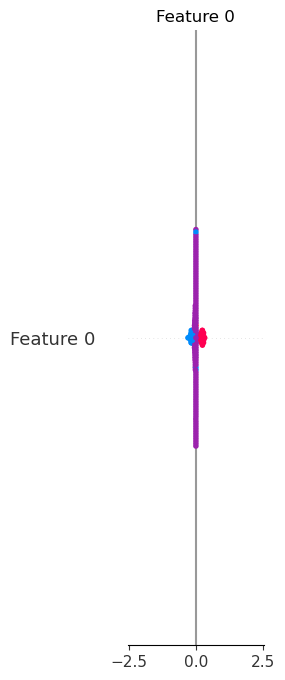

In [7]:
import shap

# 데이터를 NumPy 배열로 변환
train_numpy_x = train_tensor_x.cpu().numpy()
test_numpy_x = test_tensor_x.cpu().numpy()

# SHAP을 위한 배경 데이터 및 설명할 데이터 설정
background = train_numpy_x[:1000]
test_samples = test_numpy_x[:1000]

# 모델 예측 함수 정의
def model_predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float).to(device)
    with torch.no_grad():
        return model(data_tensor).cpu().numpy()

# KernelExplainer 생성
explainer = shap.KernelExplainer(model_predict, background)

# SHAP 값을 계산
shap_values = explainer.shap_values(test_samples, nsamples=100)

# 요약 플롯 생성
shap.summary_plot(shap_values, test_samples)

# 개별 예측의 SHAP 값을 시각화
shap.initjs()


In [10]:
# shap_values의 형태를 출력하여 확인
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Test samples shape: {test_samples.shape}")


SHAP values shape: (351, 56, 1)
Test samples shape: (351, 56)


SHAP values shape after reshaping: (351, 56)


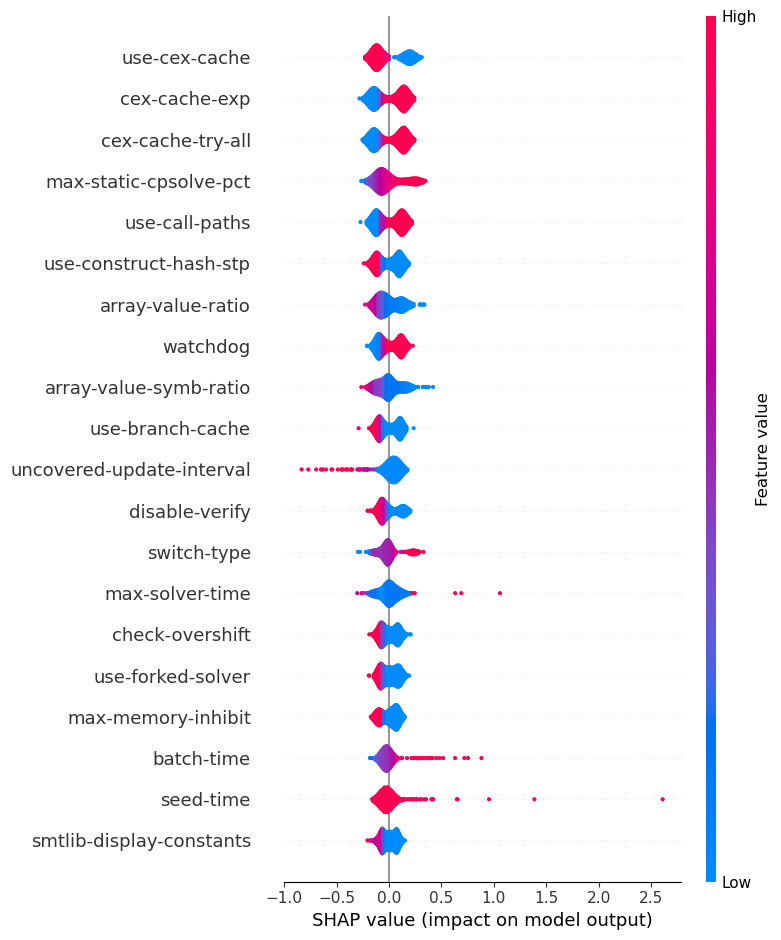

In [11]:
shap_values_reshaped = np.array(shap_values).reshape(-1, test_samples.shape[1])
print(f"SHAP values shape after reshaping: {shap_values_reshaped.shape}")

# 요약 플롯 생성
shap.summary_plot(shap_values_reshaped, test_samples, plot_type="violin", feature_names=X.columns)

In [12]:
shap_values_reshaped

array([[-0.15508638,  0.07834315,  0.        , ..., -0.13805541,
        -0.07543891,  0.06881135],
       [ 0.        , -0.15612431,  0.00881512, ..., -0.09736779,
        -0.11978171, -0.03491949],
       [-0.02033665,  0.06077197,  0.        , ...,  0.        ,
        -0.09977896,  0.05142675],
       ...,
       [-0.0767327 ,  0.10337353,  0.        , ...,  0.2321709 ,
        -0.11852764,  0.03674855],
       [-0.02074706,  0.06479393,  0.        , ..., -0.04553735,
         0.16057041,  0.02898925],
       [-0.04531498, -0.03131974, -0.00793496, ..., -0.07489027,
         0.        ,  0.        ]])

In [15]:
feature_order = np.argsort(np.sum(np.abs(shap_values_reshaped), axis=0))
feature_order

array([43,  2, 17,  3, 26, 29, 49, 11, 47,  6, 12, 45, 10, 18, 25, 24,  5,
        7, 39, 22, 36, 51, 35, 55, 23, 20, 48, 31, 16,  9, 40, 27, 13, 15,
       52, 28,  8, 32, 50,  1, 46, 33, 41,  0, 37, 34, 38, 54,  4, 19, 21,
       42, 53, 30, 14, 44])

In [108]:
df = pd.DataFrame(shap_values_reshaped, columns=X.columns)
df.to_csv('shap_values.csv', index=False)
df.to_json('shap_values.json', orient='records')